# Setup
Because we switch to `tf2`, instead of using `tf.slim`, we will use `tf.keras` for the inception model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

from tqdm.notebook import tqdm

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

DARK_READER = True
if DARK_READER:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "black",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "axes.titlecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    })

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.__version__, keras.__version__

2021-08-04 20:37:51.204308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-04 20:37:51.204364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


('2.5.0', '2.5.0')

In [4]:
inception_model = keras.applications.inception_v3.InceptionV3()
inception_model, type(inception_model)

2021-08-04 20:37:52.668377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-04 20:37:52.668425: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-04 20:37:52.668457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (homography-x220t): /proc/driver/nvidia/version does not exist


(<tensorflow.python.keras.engine.functional.Functional at 0x7f1676e74b50>,
 tensorflow.python.keras.engine.functional.Functional)

In [5]:
isinstance(inception_model, keras.Model)

True

In [6]:
def non_dunder(obj, strict=False):
    if strict:
        prefix = "_"
    else:
        prefix = "__"
    return [s for s in dir(obj) if not s.startswith(prefix)]

Since our goal is not to train new Inception weights, let's freeze the trainable parameters.

In [7]:
inception_model.trainable = False
inception_model.trainable

False

In [8]:
inception_model.trainable_weights, inception_model.trainable_variables

([], [])

In [9]:
inception_model.layers[0].input.shape

TensorShape([None, 299, 299, 3])

There are at least two aspects of Inception that is worth paying attention to

01. It expects input images of shape `(299, 299, 3)`
02. It expects input images of dtype `float32` in the range of $[-1, 1]$

The range $[-1, 1]$ will cause some trouble if we handle it carelessly. For example,

- `matplotlib` expects images of range `uint8` or $[0, 1]$ (`float32`). If you feed it an image of range $[-1, 1]$, it will simply clip values less than $0$ to $0$.


We will have to constantly changing the data range btw

- `[0..255]`
- `[0, 1]`
- `[-1, 1]`

so pay close attention to this aspect; otherwise, it will be a major source of bug and chaos.

`keras` does kindly provide us a convenience function to preprocess input images from `[0..255] or [0, 1]` to `[-1, 1]`.

> **Correction.** `preprocess_input()` **only** accept input images with data range being **`[0..255]`**.

In [10]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [11]:
original = np.random.uniform(low=0, high=1, size=(2,2,3))
processed = preprocess_input(
    original.copy()
)
# we are passing a copy because preprocess_input() seems to be inplace.
print(f"original =\n{original}\n")
print(f"processed =\n{processed}")

original =
[[[0.88227462 0.66301629 0.97258785]
  [0.37750549 0.33897365 0.66596677]]

 [[0.15471124 0.57801752 0.84241347]
  [0.5392225  0.23356515 0.25317711]]]

processed =
[[[-0.9930802  -0.99479987 -0.99237186]
  [-0.99703917 -0.99734138 -0.99477673]]

 [[-0.99878658 -0.99546653 -0.99339284]
  [-0.9957708  -0.99816812 -0.9980143 ]]]


In [12]:
original_255 = (original * 255).astype(np.uint8)
processed = preprocess_input(
    original_255.copy()
)
# we are passing a copy because preprocess_input() seems to be inplace.
print(f"original_255 =\n{original_255}\n")
print(f"processed =\n{processed}")

original_255 =
[[[224 169 248]
  [ 96  86 169]]

 [[ 39 147 214]
  [137  59  64]]]

processed =
[[[ 0.75686276  0.32549024  0.94509804]
  [-0.24705881 -0.32549018  0.32549024]]

 [[-0.69411767  0.15294123  0.6784314 ]
  [ 0.07450986 -0.5372549  -0.4980392 ]]]


In [13]:
original = tf.constant(
    np.random.randint(low=0, high=255, size=(2,2,3)),
    dtype=tf.float32,
)
#random_tensor.dtype
processed = preprocess_input(original)
print(f"original =\n{original}\n")
print(f"processed =\n{processed}")

original =
[[[230. 190. 239.]
  [126. 209. 254.]]

 [[ 56. 111.  50.]
  [ 97. 234.  49.]]]

processed =
[[[ 0.8039216   0.4901961   0.8745098 ]
  [-0.01176471  0.6392157   0.99215686]]

 [[-0.56078434 -0.12941176 -0.60784316]
  [-0.23921567  0.8352941  -0.6156863 ]]]


Let's wrap this preprocessing function around the Keras Inception model to make a frequently used function in future steps.

In [14]:
def inception(image):
    if isinstance(image, tf.Variable):
        #image.assign(preprocess_input(image.numpy()))
        # No need, because our tf.Variable is already of dtype float32
        pass
    #elif isinstance(image, np.ndarray) and image.dtype == np.uint8:
    elif isinstance(image, np.ndarray):
        if image.dtype == np.uint8:
            image = preprocess_input(image)
        if image.dtype in (np.float32, np.float64) and not np.any(image < 0):
            # i.e. data range [0, 1]
            image = 2*image - 1

    # For tf.Tensor and np.ndarray, len(image.shape) equals image.ndims,
    # but since we also expect input as tf.Variable, we have to use len(image.shape)
    if len(image.shape) == 3:
        image_batch = tf.expand_dims(image, axis=0)

    return inception_model(image_batch)[0]

In [15]:
import json
from pathlib import Path
from urllib.request import urlretrieve

In [16]:
imagenet_json = Path("imagenet.json")
if not imagenet_json.exists():
    imagenet_json, _ = urlretrieve(
        'https://www.anishathalye.com/media/2017/07/25/imagenet.json',
        imagenet_json,
    )

with open(imagenet_json) as f:
    imagenet_labels = json.load(f)
sorted(imagenet_labels)

['Afghan hound, Afghan',
 'African chameleon, Chamaeleo chamaeleon',
 'African crocodile, Nile crocodile, Crocodylus niloticus',
 'African elephant, Loxodonta africana',
 'African grey, African gray, Psittacus erithacus',
 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 'Airedale, Airedale terrier',
 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 'American alligator, Alligator mississipiensis',
 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 'American chameleon, anole, Anolis carolinensis',
 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 'American egret, great white heron, Egretta albus',
 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 'Angora, Angora rabbit',
 'Appenzeller',
 'Arabian camel, dromedary, Camelus dromedarius',
 'Arctic fox, white fox, Alopex lagopus',
 'Australian terrier',
 'Band Aid',
 'Bedlington terrier',
 'Bernese mou

In [17]:
len(imagenet_labels)

1000

In [18]:
#img_path = Path("images/cat.jpg")
img_path = Path("cat.jpg")
if not img_path.exists():
    img_path, _ = urlretrieve(
        'https://www.anishathalye.com/media/2017/07/25/cat.jpg',
        img_path
    )
img_class = imagenet_labels.index("tabby, tabby cat")
#img_class = imagenet_labels.index("desktop computer")
imagenet_labels[img_class]

'tabby, tabby cat'

In [19]:
img = Image.open(img_path)

# Resize the image such that its smaller side is of 299 pixels,
# keeping its aspect ratio, and finally crop to the top left 299x299.
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))

#img = (np.asarray(img) / 255.0).astype(np.float32)
#img = np.asarray(img, dtype=np.float32)
img = np.asarray(img)
img.shape, img.dtype, img.max(), img.min()

((299, 299, 3), dtype('uint8'), 255, 0)

The output of the function `inception()` is a probability vector. To have an easier-to-understand prediction, the following function might help.

In [20]:
def top(array, k=10):
    return [imagenet_labels[index] for index in tf.argsort(probas, direction="DESCENDING")[:k]]

In [21]:
#image = tf.random.uniform(shape=(299,299,3), minval=-1, maxval=1)
probas = inception(img)
top(probas)

['tabby, tabby cat',
 'tiger cat',
 'Egyptian cat',
 'lynx, catamount',
 'swab, swob, mop',
 'plastic bag',
 'radiator',
 'pot, flowerpot',
 'carton',
 'radio, wireless']

It's good to see the top predicted classes in the inference, but it's even better to visualize the image, the probability and the predicted classes altogether. The following function `classify()` is written for that purpose.

In [22]:
np.any(img >= 0), np.all(img >= 0)

(True, True)

In [23]:
def inverse_preprocess(array, uint8=False):
    """
    args
        array, 
            range [-1, 1]
    """
    if isinstance(array, tf.Tensor) or isinstance(array, tf.Variable):
        #array = array.numpy()
        array = array.numpy().copy()
    array01 = (array + 1) / 2
    if uint8:
        return (array01 * 255).astype(np.uint8)
    else:
        return array01

In [24]:
def classify(img, correct_class=None, target_class=None, k=10, n_chars=15):
    """
    args
        img, tf.Variable or tf.Tensor or np.ndarray
            The image to be displayed, along with Inception's inference
        correct_class, int
            class id for the truth class of img
        target_class, int
            class id for the targeted attack class

    Rmk. Pay attention to img, please. We expect img to be either one of the following
    
    - tf.Variable
    - tf.Tensor
    - np.ndarray

    Not only are we going to imshow(img), but we also will inception(img) to make inference.
    This means that we need to adapt the data range of img:

    - When imshow(img), data range has to be [0..255] or [0, 1]
    - When inception(img), data range has to be [-1, 1]
    """
    if isinstance(img, tf.Variable) or isinstance(img, tf.Tensor):
        if img.dtype == tf.uint8:
            img_inception = preprocess_input(img.numpy())
            img_plt = img.numpy()
        elif img.dtype == tf.float32:
            if tf.reduce_min(img) < 0:
                img_inception = img.numpy()
                img_plt = inverse_preprocess(img.numpy())
            else:
                img_inception = preprocess_input(img.numpy() * 255)
                img_plt = img.numpy()
    elif isinstance(img, np.ndarray):
        if img.dtype == np.uint8:
            img_inception = preprocess_input(img)
            img_plt = img
        elif img.dtype == np.float32:
            if np.any(img < 0):
                img_inception = img
                img_plt = inverse_preprocess(img)
            else:
                img_inception = preprocess_input(img * 255)
                img_plt = img
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
    fig.sca(ax1)
    ax1.imshow(img_plt)
    probas = inception(img_inception)
    probas = probas.numpy()
    
    # display the top k prediceted classes
    topk = list((tf.argsort(probas, direction="DESCENDING")[:k]).numpy())
    # We convert topk to a list because we'd like to use its index() method later.
    top_probas = probas[topk]
    barlist = ax2.bar(range(k), top_probas)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(k),
               [imagenet_labels[i][:n_chars] for i in topk],
               #[imagenet_labels[i].strip(",")[0] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)

In [25]:
try:
    [1,2,3].index(2.71828)
except ValueError as e:
    print(f"ValueError: {e}")

ValueError: 2.71828 is not in list


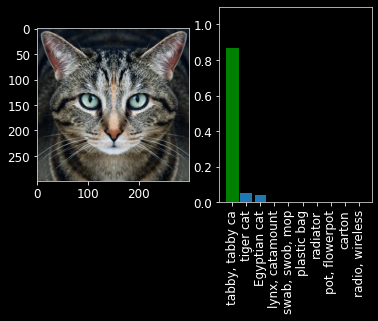

In [26]:
classify(img, correct_class=img_class)

In [27]:
isinstance(tf.Variable(10), tf.Tensor)

False

In [28]:
isinstance(tf.Variable(10), tf.Variable)

True

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ <del>box</del> ball with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using [backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

In [30]:
#image = tf.Variable(img, dtype=tf.float32)
image = tf.Variable(tf.zeros((299,299,3), dtype=tf.float32))
#x_hat = image

#x_hat.dtype, x_hat.shape
image.dtype, image.shape

(tf.float32, TensorShape([299, 299, 3]))

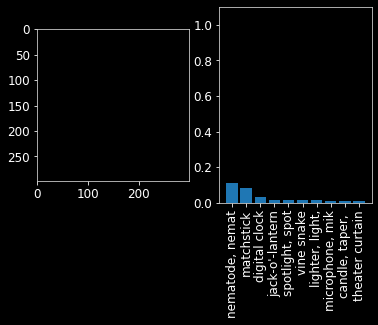

In [31]:
#classify(x_hat)
classify(image)

In [33]:
top(inception(image), k=1000).index("desktop computer")

606

In [34]:
px_epsilon = 2.0/255.0 # a really small tolerated perturbation
px_epsilon

0.00784313725490196

In [35]:
img_processed = keras.applications.inception_v3.preprocess_input(img)
below = img_processed - px_epsilon
below = np.clip(below, -1, 1)
above = img_processed + px_epsilon
above = np.clip(above, -1, 1)
print(f"img[:2, :2, 0] =\n{img[:2, :2, 0]}\n")
print(f"img_processed[:2, :2, 0] =\n{img_processed[:2, :2, 0]}\n")
print(f"below[:2, :2, 0] =\n{below[:2, :2, 0]}\n")
print(f"above[:2, :2, 0] =\n{above[:2, :2, 0]}")

img[:2, :2, 0] =
[[14 14]
 [15 16]]

img_processed[:2, :2, 0] =
[[-0.8901961  -0.8901961 ]
 [-0.88235295 -0.8745098 ]]

below[:2, :2, 0] =
[[-0.8980392  -0.8980392 ]
 [-0.8901961  -0.88235295]]

above[:2, :2, 0] =
[[-0.88235295 -0.88235295]
 [-0.8745098  -0.8666667 ]]


In [37]:
lr = 300
n_steps = 30
#target_name = "banana"
target_name = "desktop computer"
target_class = imagenet_labels.index(target_name)

x_hat = tf.Variable(tf.zeros((299,299,3), dtype=tf.float32))
best_proba = 0
for i in tqdm(range(n_steps)):
    with tf.GradientTape() as tape:
        tape.watch(x_hat)
        proba = inception(x_hat)[target_class]
    
    if (i+1) % 10 == 0:
        #print(f'step{i+1: 4d}, proba={proba:.9f}')
        print(f'step{i+1: 4d}')
        print(f"best_proba = {best_proba:.6f}")
        print(f"proba      = {proba.numpy():6f}")
        if proba.numpy() > best_proba:
            x_best = x_hat.numpy().copy()
            best_proba = proba
            
    grad = tape.gradient(proba, [x_hat])[0]
    projected = tf.clip_by_value(x_hat + lr * grad, below, above)
    x_hat.assign(projected)

  0%|          | 0/30 [00:00<?, ?it/s]

step  10
best_proba = 0.000000
proba      = 0.000053
step  20
best_proba = 0.000053
proba      = 0.000226
step  30
best_proba = 0.000226
proba      = 0.003088


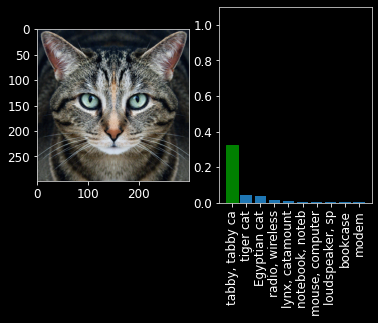

In [38]:
classify(
    x_hat,
    correct_class=img_class,
    target_class=target_class,
)

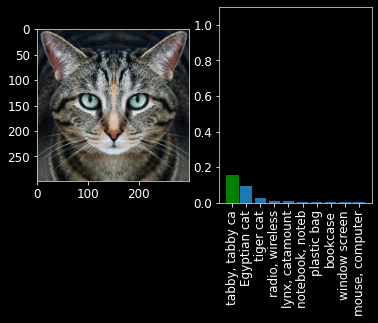

In [39]:
classify(
    x_best,
    correct_class=img_class,
    target_class=target_class,
)

In [40]:
top(inception(x_best), k=1000).index(target_name)

606

In [41]:
top(inception(x_hat), k=1000).index(target_name)

606

In [42]:
proba, inception(x_best)[target_class], inception(image)[target_class]

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0030875192>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0030875192>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0012762478>)

In [43]:
sum_probas =  (top(inception(x_best), k=1000).index(target_name) - 1) * proba
if sum_probas > 1:
    print(f"Unreasonable: sum_probas = {sum_probas} > 1")

Unreasonable: sum_probas = 1.86794912815094 > 1


In [44]:
#target_class = imagenet_labels.index("desktop computer")
lr = 3e-1
n_steps = 100

x_hat = tf.Variable(tf.zeros((299,299,3), dtype=tf.float32))

for i in tqdm(range(n_steps)):
    with tf.GradientTape() as tape:
        probas = inception(x_hat)
        loss = keras.losses.sparse_categorical_crossentropy(target_class, probas)
        
    grad = tape.gradient(loss, [x_hat])[0]
    projected = tf.clip_by_value(x_hat - lr * grad, below, above)
    x_hat.assign(projected)
    
    if (i+1) % 10 == 0:
        print(f'step{i+1: 4d}, loss={loss:.6f}, proba={probas[target_class].numpy():.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]

step  10, loss=5.678248, proba=0.003420
step  20, loss=4.254927, proba=0.014194
step  30, loss=3.444849, proba=0.031910
step  40, loss=3.070733, proba=0.046387
step  50, loss=2.516899, proba=0.080709
step  60, loss=2.209092, proba=0.109800
step  70, loss=2.231972, proba=0.107317
step  80, loss=1.966051, proba=0.140009
step  90, loss=1.844816, proba=0.158054
step 100, loss=1.955728, proba=0.141461


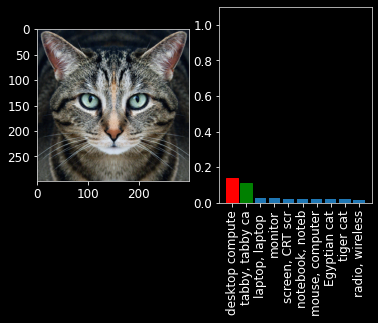

In [46]:
classify(
    x_hat,
    correct_class=img_class,
    target_class=target_class,
)

In [47]:
probas[target_class]

<tf.Tensor: shape=(), dtype=float32, numpy=0.14146142>

In [48]:
top(inception(x_hat))

['desktop computer',
 'tabby, tabby cat',
 'monitor',
 'tiger cat',
 'laptop, laptop computer',
 'Egyptian cat',
 'mouse, computer mouse',
 'radio, wireless',
 'screen, CRT screen',
 'notebook, notebook computer']

> Did you notice that the ranking above is slightly diff?